18118


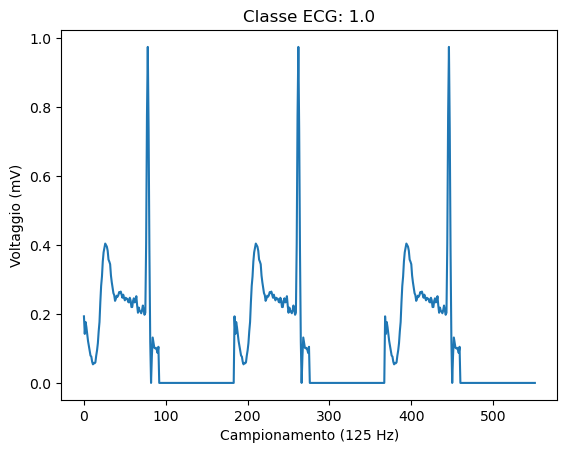

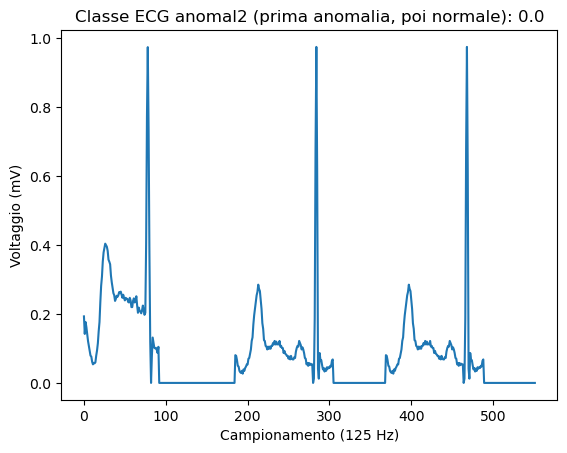

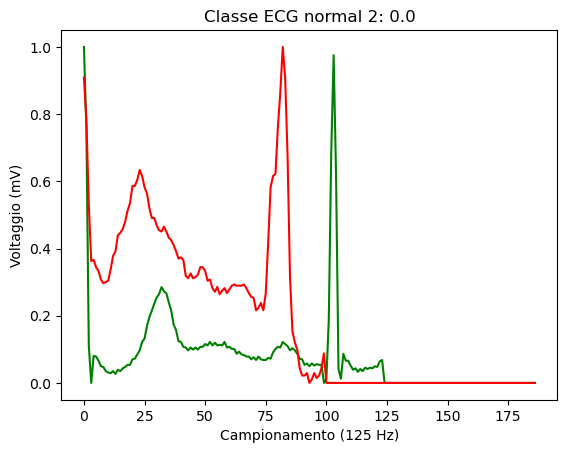

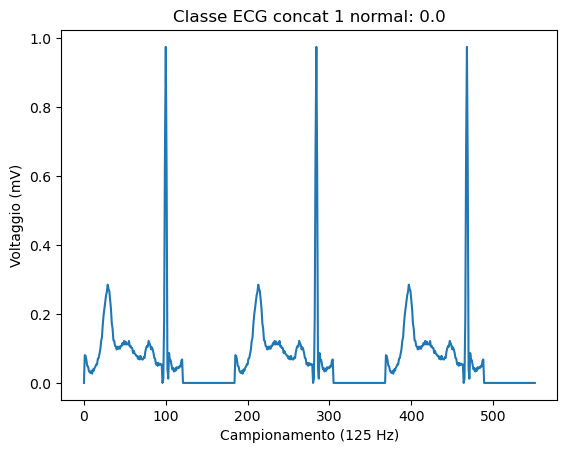

In [1]:
import math
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import warnings

# Carica il dataset
df = pd.read_csv('C:/Users/Rosa/Desktop/tirocinio/tesi/mitbih_test.csv', header=None)

# Estrai segnale ed etichetta
for i in range(21892):
    if df.iloc[i,-1] != 0: 
        ecg_signal_anomal = np.concatenate((df.iloc[i, 3:-1].values, df.iloc[i, 3:-1].values, df.iloc[i, 3:-1].values))  # Prima riga (senza etichetta)
        label = df.iloc[i, -1]  # Etichetta della prima riga
        print(i)
        plt.plot(ecg_signal_anomal)
        plt.title(f"Classe ECG: {label}")
        plt.xlabel("Campionamento (125 Hz)")
        plt.ylabel("Voltaggio (mV)")
        plt.show()
        break
ecg_signal_normal1 = df.iloc[0, :-1].values  # Prima riga (senza etichetta)
label = df.iloc[0, -1]  # Etichetta della prima riga
ecg_signal_normal2 = df.iloc[1, :-1].values  # seconda riga (senza etichetta)
label = df.iloc[1, -1]  # Etichetta della seconda riga
ecg_concat1 = np.concatenate((df.iloc[0, 3:-1].values, df.iloc[0, 3:-1].values, df.iloc[0, 3:-1].values))
ecg_anomal2 = np.concatenate((df.iloc[18118, 3:-1].values, df.iloc[0, 3:-1].values, df.iloc[0, 3:-1].values))
#print(df.iloc[:,-1])

plt.plot(ecg_anomal2)
plt.title(f"Classe ECG anomal2 (prima anomalia, poi normale): {label}")
plt.xlabel("Campionamento (125 Hz)")
plt.ylabel("Voltaggio (mV)")
plt.show()

# Visualizza
plt.plot(ecg_signal_normal1, 'g')
plt.title(f"Classe ECG normal 1: {label}")
plt.xlabel("Campionamento (125 Hz)")
plt.ylabel("Voltaggio (mV)")
plt.plot(ecg_signal_normal2, 'r')
plt.title(f"Classe ECG normal 2: {label}")
plt.xlabel("Campionamento (125 Hz)")
plt.ylabel("Voltaggio (mV)")
plt.show()

plt.plot(ecg_concat1)
plt.title(f"Classe ECG concat 1 normal: {label}")
plt.xlabel("Campionamento (125 Hz)")
plt.ylabel("Voltaggio (mV)")
plt.show()

In [2]:
def update_thresholds(peak, is_qrs, SPKI, NPKI):
    if is_qrs:
        SPKI = 0.125 * peak + 0.875 * SPKI
    else:
        NPKI = 0.125 * peak + 0.875 * NPKI

    threshold_I1 = NPKI + 0.25 * (SPKI - NPKI)
    threshold_I2 = 0.5 * threshold_I1
    return SPKI, NPKI, threshold_I1, threshold_I2

def detect_r_peaks(sign, fs=250, show_plot=False):
    """
    Rilevamento picchi R ECG senza librerie (tranne matplotlib per i grafici)
    
    Args:
        signal: lista o array di valori ECG
        fs: frequenza di campionamento (Hz)
        show_plot: se True mostra il grafico di debug
    
    Returns:
        lista degli indici dei picchi R rilevati
    """
    # 1. Pre-elaborazione base
    mean = sum(sign)/len(sign)
    normalized = [x - mean for x in sign]
    plt.figure(figsize=(12, 4))
    plt.plot(sign, label='sign')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12, 4))
    plt.plot(normalized, label='normalized')
    plt.legend()
    plt.show()
    
    # 2. Calcolo della derivata approssimata (senza numpy) 
    derivative = []
    for i in range(1, len(normalized)):
        derivative.append(normalized[i] - normalized[i-1])
    
               
    plt.figure(figsize=(12, 4))
    plt.plot(derivative, label='derivate')
    plt.legend()
    plt.show()
        
    # 3. Quadratura del segnale (enfatizza i picchi)
    squared = [x**2 for x in derivative]
    
    plt.figure(figsize=(12, 4))
    plt.plot(squared, label='squared')
    plt.legend()
    plt.show()
    
    # 4. Media mobile per smoothing (finestra 150ms)
    window_size = int(0.2 * fs)
    integrated = []
    for i in range(len(squared)): #window_size, 
        start = max(0, i - window_size//2)
        end = min(len(squared), i + window_size//2)
        window = squared[start:end]
        integrated.append(sum(window)/len(window))
    
        
    # 5. Soglia adattiva
    NPKI = 0.0
    SPKI = sum(integrated)/len(integrated)
    #SPKI = max(integrated[:int(2 * fs)]) #massimo per i primi 2 secondi
    threshold_I1 = NPKI + 0.25 * (SPKI - NPKI)
    refractory = int(0.2 * fs) #0.2
    last_qrs = -999
    qrs_peaks = []
    for i in range(len(integrated)):
        if ecg_concat1[i] > ecg_concat1[i - 1] and ecg_concat1[i] > ecg_concat1[i + 1] :
            peak_val = ecg_concat1[i]
            if peak_val > threshold_I1 and (i- last_qrs) > refractory: 
                #SPKI, NPKI, threshold_I1, threshold_I2 = update_thresholds(peak_val, True, SPKI, NPKI)
                SPKI = 0.125 * peak_val + 0.875 * SPKI
                threshold_I1 = NPKI + 0.25 * (SPKI - NPKI)
                qrs_peaks.append(i)
                last_qrs = i 
            else:
                NPKI = 0.125 * peak_val + 0.875 * NPKI
                threshold_I1 = NPKI + 0.25 * (SPKI - NPKI)
    print(qrs_peaks)   
   
    final_peaks = []
    amplitude_thresh = 0.5 * max(sign)

    for i, peak in enumerate(qrs_peaks):
    # Accetta sempre primo e ultimo picco, altrimenti controlla la distanza 
        if not final_peaks or i == 0 or i == len(qrs_peaks) - 1 or (peak - final_peaks[-1] > refractory):
            search_window = int(0.2 * fs) if (i == 0 or i == len(qrs_peaks) - 1) else int(0.2 * fs)
            search_start = int(max(0, peak - search_window))
            search_end = int(min(len(sign), peak + search_window))
        
        # Trova il massimo vero nel segnale originale
            max_val = -math.inf
            true_peak = peak
            for j in range(search_start, search_end):
                if sign[j] > max_val:
                    max_val = sign[j]
                    true_peak = j
            if sign[true_peak] >= amplitude_thresh:
                final_peaks.append(true_peak)
           # for i in range(len(final_peaks)-1):
               # if abs(final_peaks[i] - final_peaks[i+1] < refractory):
                 #   minimum = min(sign[final_peaks[i]],sign[final_peaks[i+1]])
                   # index = sign.index(minimum)
                   # final_peaks.remove(index)
                    
           
   # final_peaks.pop(0)
    print(max(sign))
            
    plt.figure(figsize=(12, 4))
    plt.plot(sign, label='ECG')
    plt.scatter(final_peaks, [sign[p] for p in final_peaks], c='red', label='Picchi rilevati')
    #plt.scatter([peaks[0], peaks[-1]], [sign[peaks[0]], sign[peaks[-1]]], c='green', marker='x', s=100, label='Primo/Ultimo picco grezzo')
    plt.legend()
    plt.show()
    return final_peaks


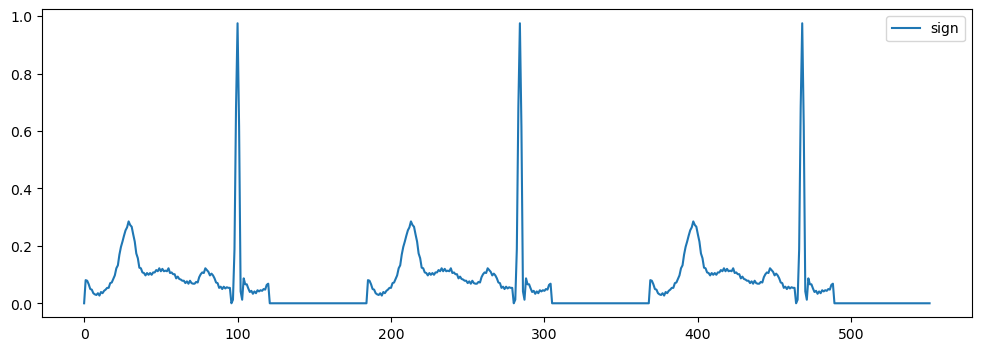

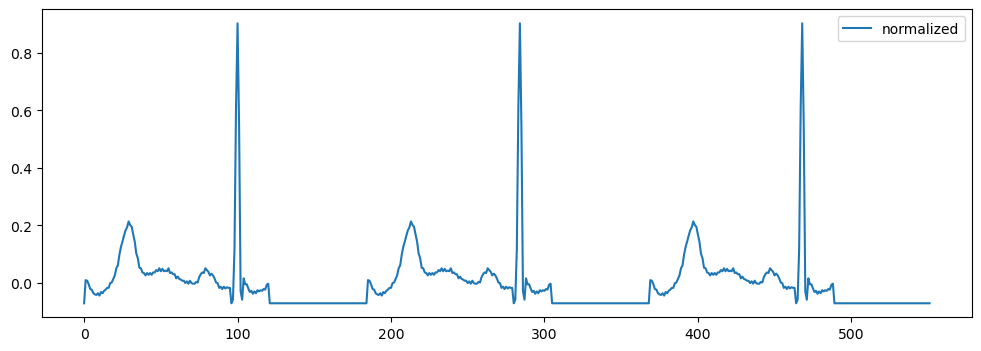

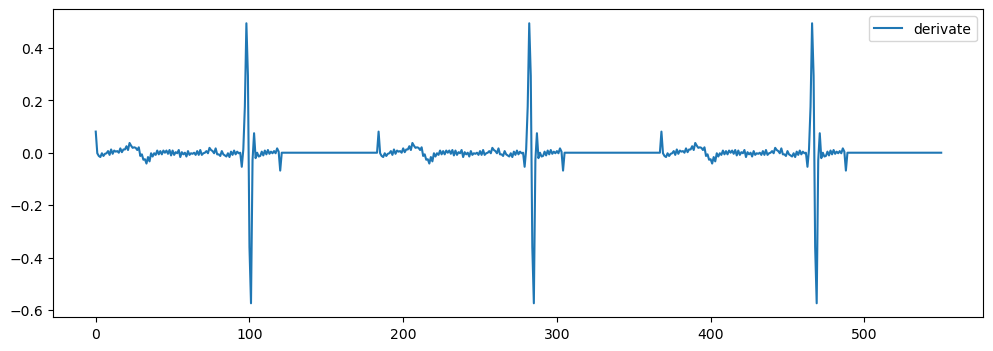

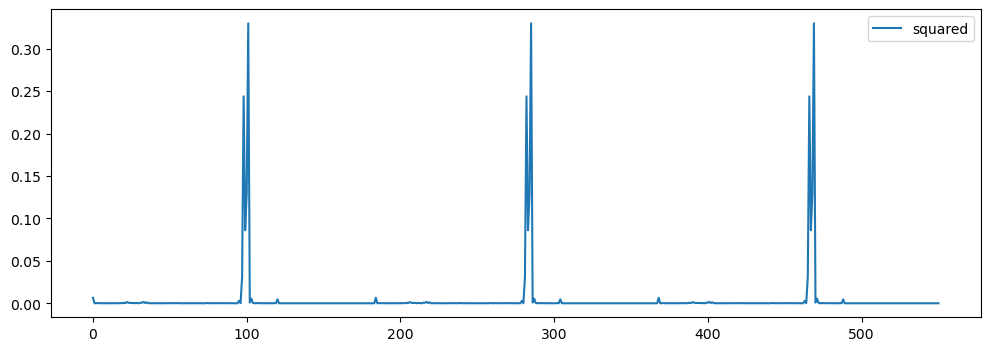

[1, 53, 213, 267, 397, 451]
0.9752066135406494


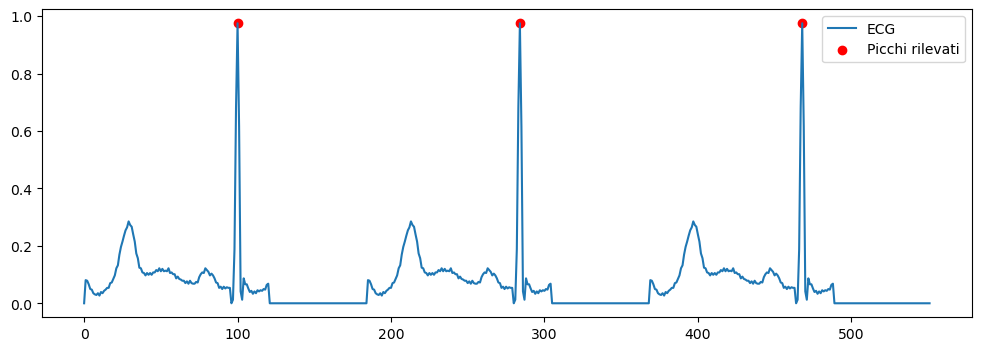

[100, 284, 468]


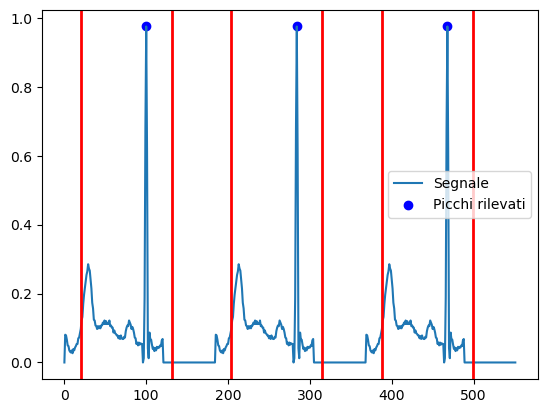

In [3]:
c = detect_r_peaks(ecg_concat1, fs=250)
#plt.plot(treshold)
plt.plot(ecg_concat1, label='Segnale')
plt.scatter(c, [ecg_concat1[p] for p in c], c='blue', label='Picchi rilevati')
#print(c, ecg_concat1[c])
maximum = []
for i in range(len(ecg_concat1)):
    if ecg_concat1[i] == max(ecg_concat1):
        maximum.append(i)
print(maximum)
for i in c:
    if i > 16 and i < ecg_concat1.shape[0]-31:
        plt.axvline(x=i-80, color='red', linestyle='-', linewidth=2)
        plt.axvline(x=i+31, color='red', linestyle='-', linewidth=2)
        
plt.legend()

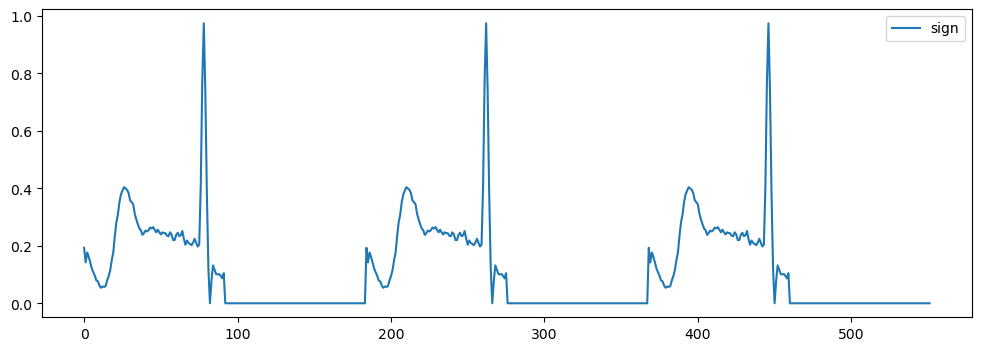

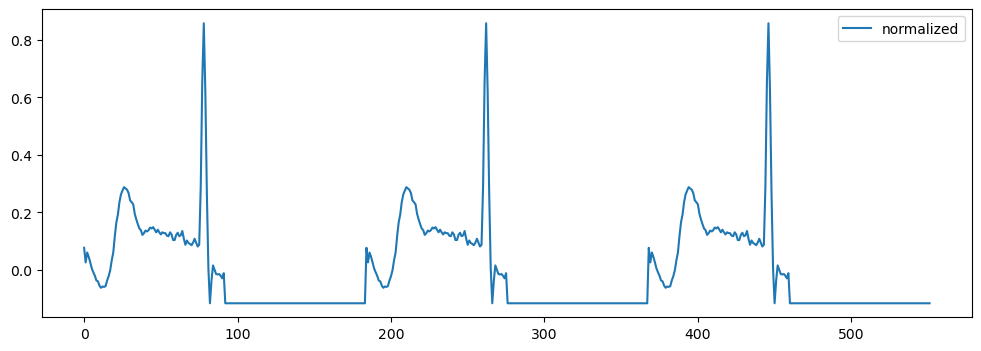

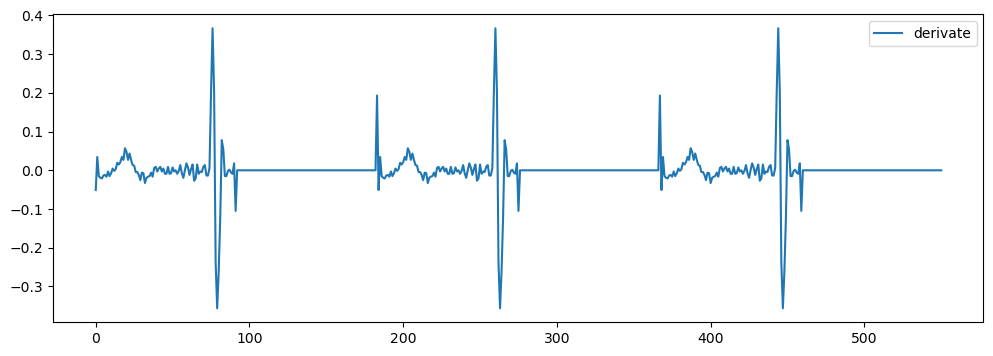

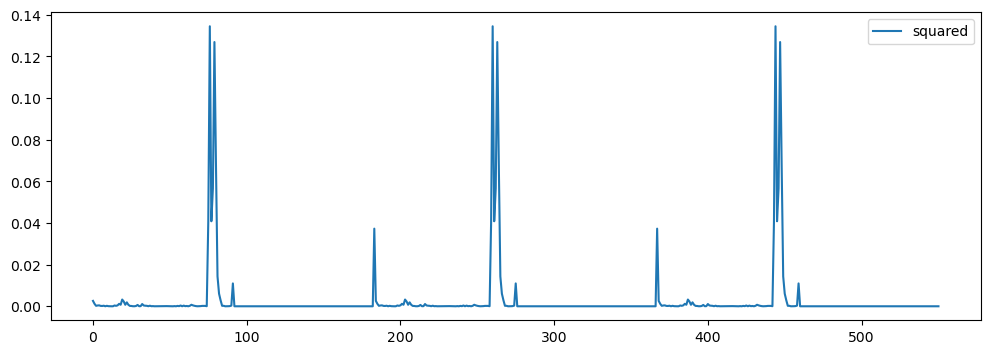

[1, 53, 213, 267, 397, 451]
0.9745509028434752


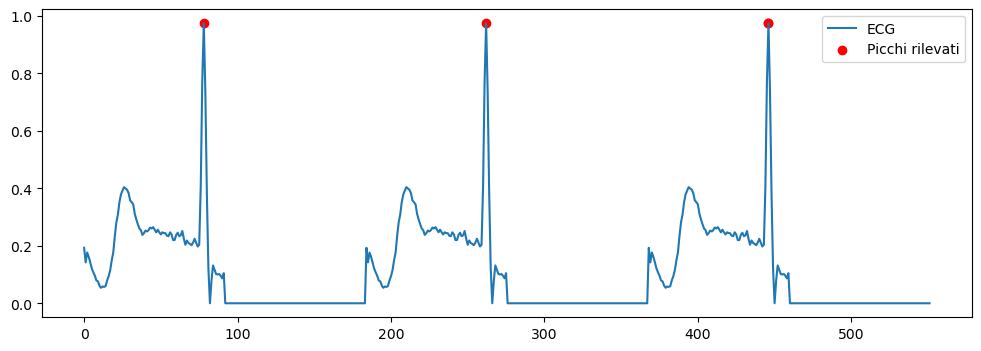

[100, 284, 468]


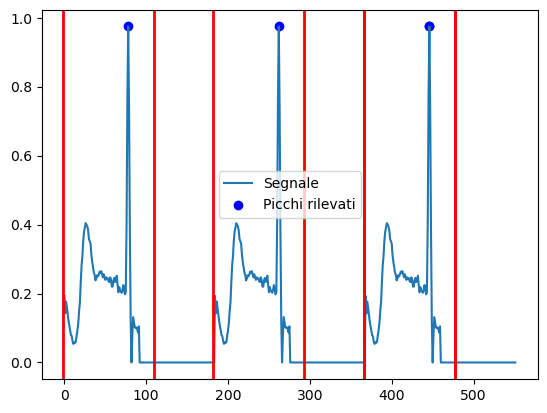

In [4]:
c = detect_r_peaks(ecg_signal_anomal, fs=250)
#plt.plot(treshold)
plt.plot(ecg_signal_anomal, label='Segnale')
plt.scatter(c, [ecg_signal_anomal[p] for p in c], c='blue', label='Picchi rilevati')
#print(c, ecg_concat1[c])
maximum = []
for i in range(len(ecg_concat1)):
    if ecg_concat1[i] == max(ecg_concat1):
        maximum.append(i)
print(maximum)
for i in c:
    if i > 16 and i < ecg_concat1.shape[0]-31:
        plt.axvline(x=i-80, color='red', linestyle='-', linewidth=2)
        plt.axvline(x=i+31, color='red', linestyle='-', linewidth=2)
        
plt.legend()

20284


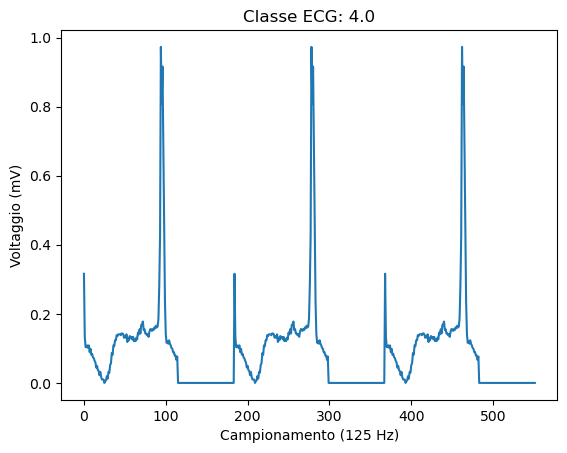

20122


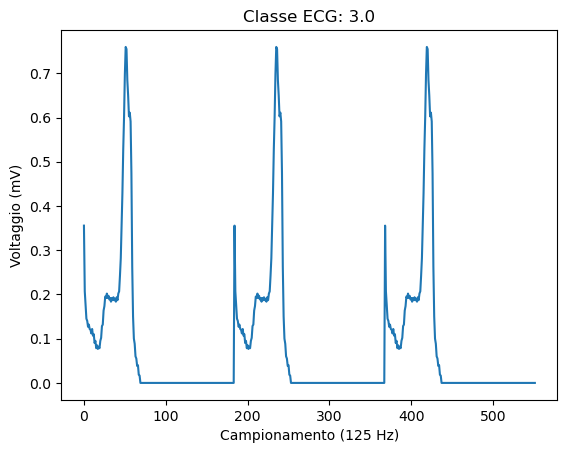

18674


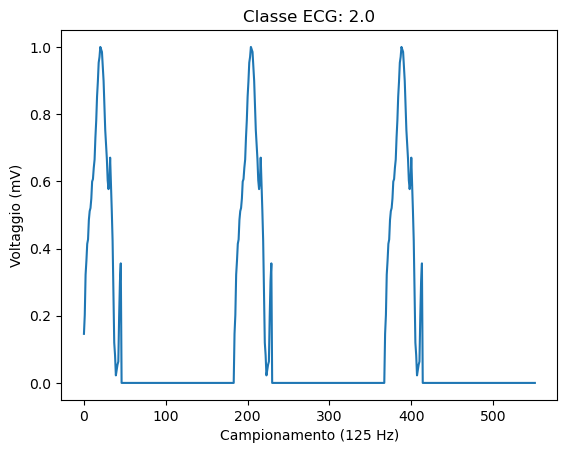

In [5]:
for i in range(21892):
    if df.iloc[i,-1] == 4: 
        ecg_signal_anomal4 = np.concatenate((df.iloc[i, 3:-1].values, df.iloc[i, 3:-1].values, df.iloc[i, 3:-1].values))  # Prima riga (senza etichetta)
        label = df.iloc[i, -1]  # Etichetta della prima riga
        print(i)
        plt.plot(ecg_signal_anomal4)
        plt.title(f"Classe ECG: {label}")
        plt.xlabel("Campionamento (125 Hz)")
        plt.ylabel("Voltaggio (mV)")
        plt.show()
        break

for i in range(21892):
    if df.iloc[i,-1] == 3: 
        ecg_signal_anomal3 = np.concatenate((df.iloc[i, 3:-1].values, df.iloc[i, 3:-1].values, df.iloc[i, 3:-1].values))  # Prima riga (senza etichetta)
        label = df.iloc[i, -1]  # Etichetta della prima riga
        print(i)
        plt.plot(ecg_signal_anomal3)
        plt.title(f"Classe ECG: {label}")
        plt.xlabel("Campionamento (125 Hz)")
        plt.ylabel("Voltaggio (mV)")
        plt.show()
        break
        
for i in range(21892):
    if df.iloc[i,-1] == 2: 
        ecg_signal_anomal2 = np.concatenate((df.iloc[i, 3:-1].values, df.iloc[i, 3:-1].values, df.iloc[i, 3:-1].values))  # Prima riga (senza etichetta)
        label = df.iloc[i, -1]  # Etichetta della prima riga
        print(i)
        plt.plot(ecg_signal_anomal2)
        plt.title(f"Classe ECG: {label}")
        plt.xlabel("Campionamento (125 Hz)")
        plt.ylabel("Voltaggio (mV)")
        plt.show()
        break

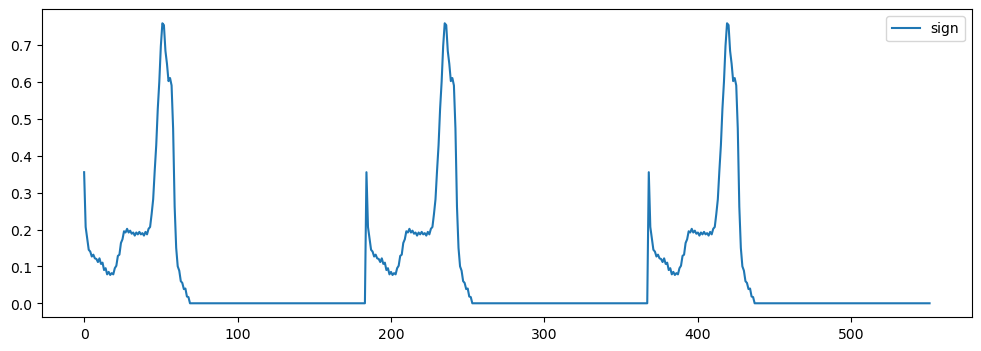

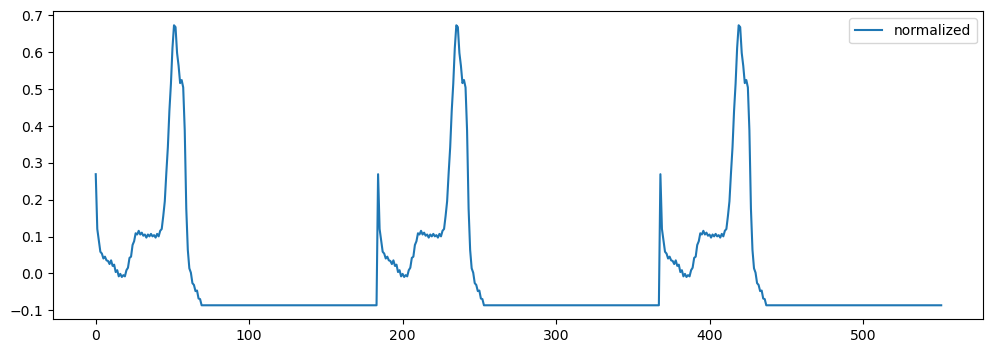

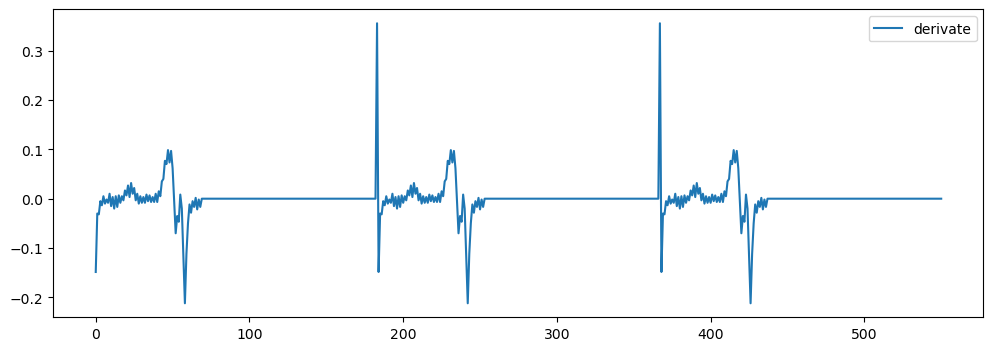

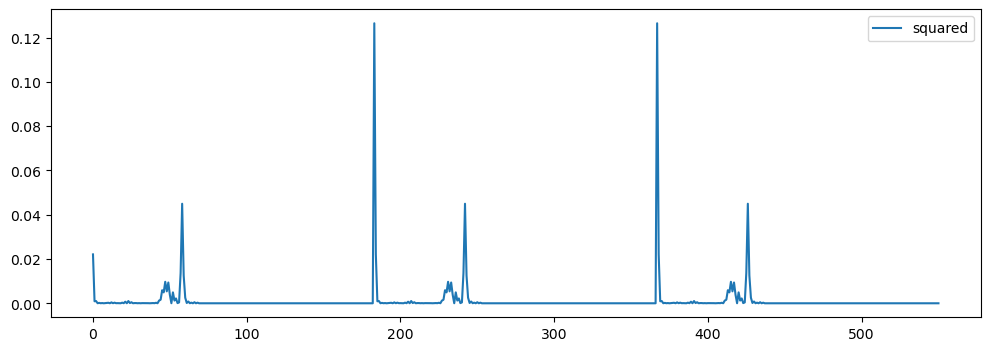

[1, 53, 213, 267, 397, 451]
0.7595993280410767


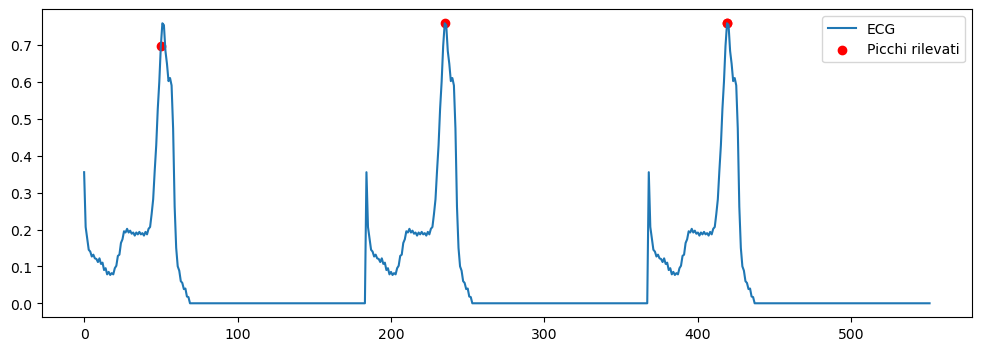

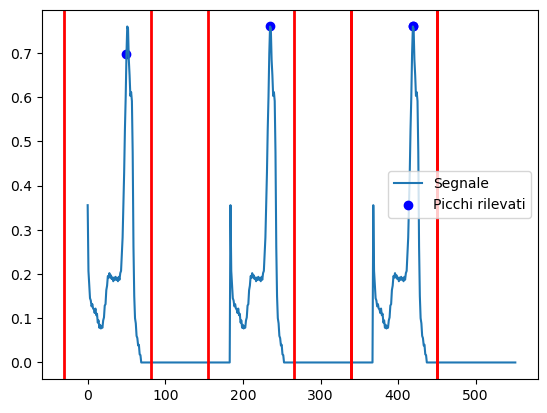

In [6]:
c = detect_r_peaks(ecg_signal_anomal3, fs=250)
#plt.plot(treshold)
plt.plot(ecg_signal_anomal3, label='Segnale')
plt.scatter(c, [ecg_signal_anomal3[p] for p in c], c='blue', label='Picchi rilevati')
#print(c, ecg_concat1[c])
for i in c:
    if i > 16 and i < ecg_concat1.shape[0]-31:
        plt.axvline(x=i-80, color='red', linestyle='-', linewidth=2)
        plt.axvline(x=i+31, color='red', linestyle='-', linewidth=2)
        
plt.legend()

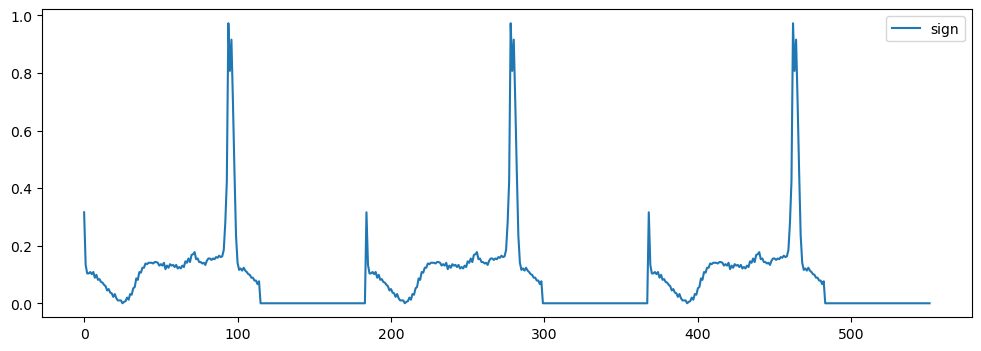

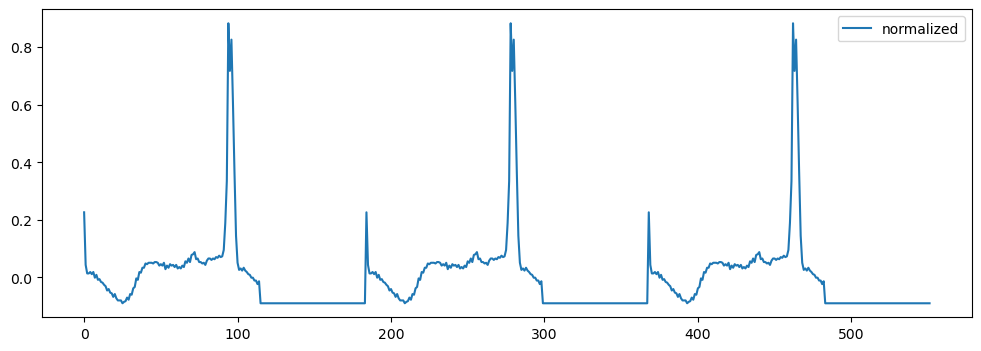

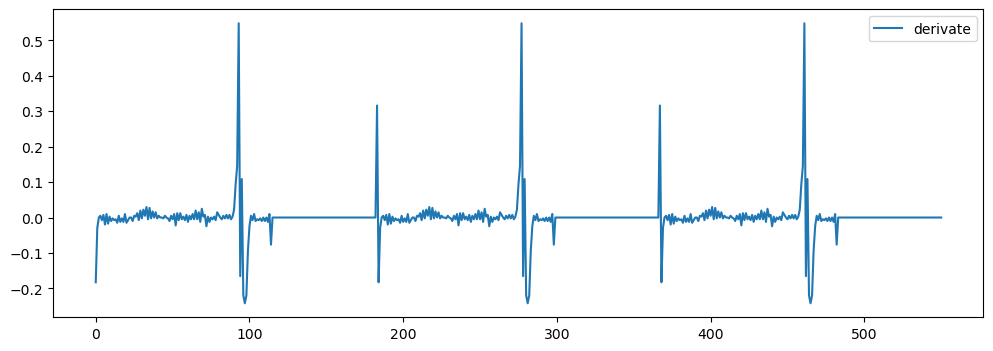

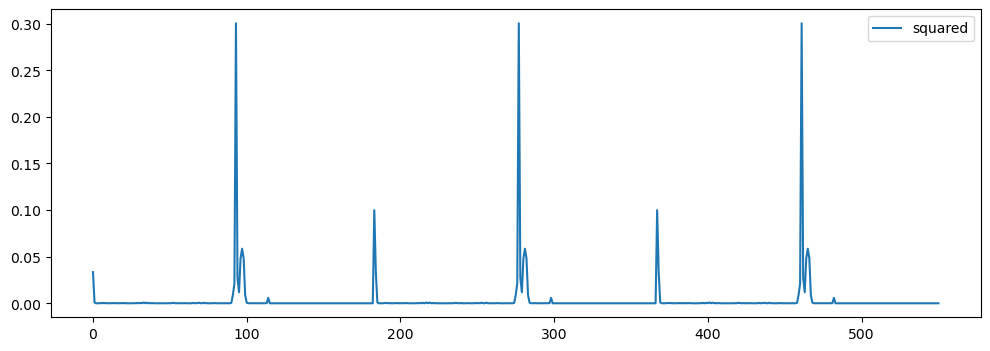

[1, 53, 213, 267, 397, 451]
0.9728395342826844


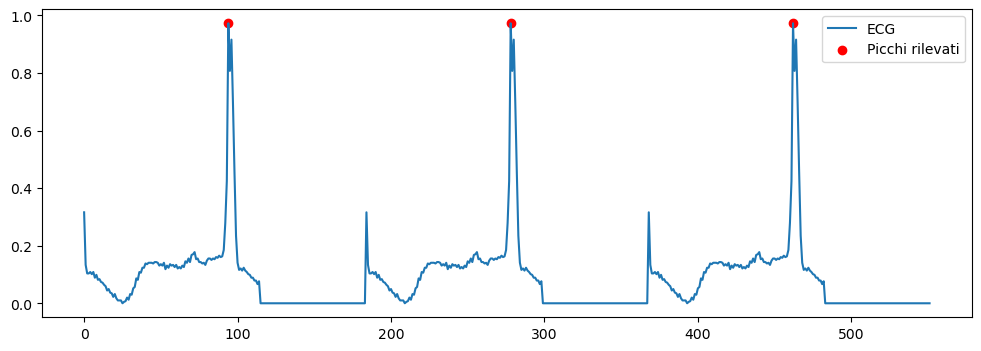

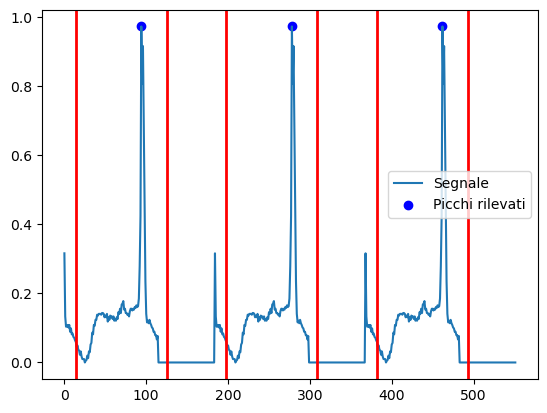

In [7]:
c = detect_r_peaks(ecg_signal_anomal4, fs=250)
#plt.plot(treshold)
plt.plot(ecg_signal_anomal4, label='Segnale')
plt.scatter(c, [ecg_signal_anomal4[p] for p in c], c='blue', label='Picchi rilevati')
#print(c, ecg_concat1[c])
for i in c:
    if i > 16 and i < ecg_concat1.shape[0]-31:
        plt.axvline(x=i-80, color='red', linestyle='-', linewidth=2)
        plt.axvline(x=i+31, color='red', linestyle='-', linewidth=2)
        
plt.legend()

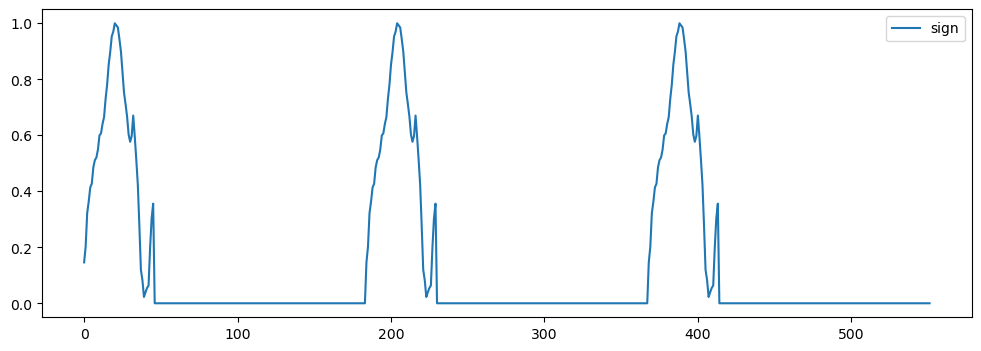

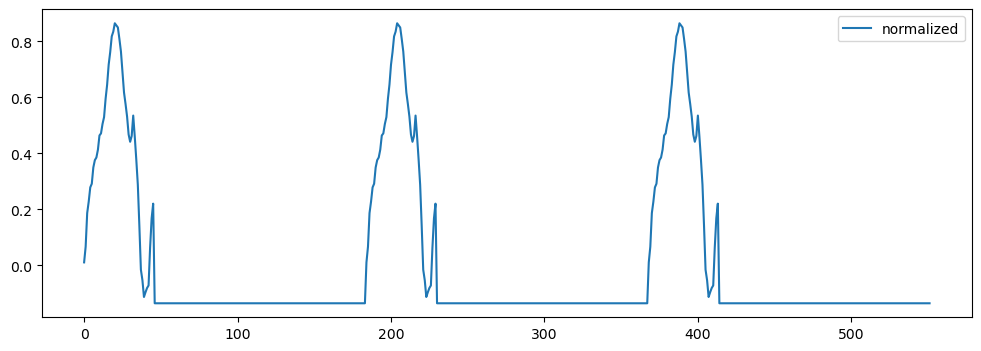

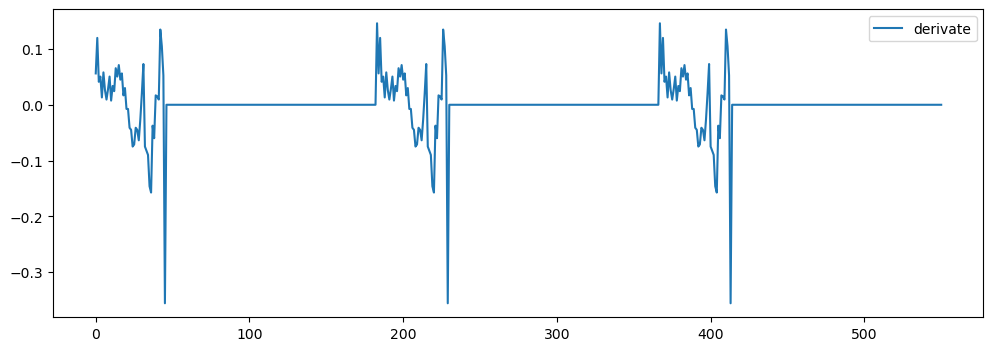

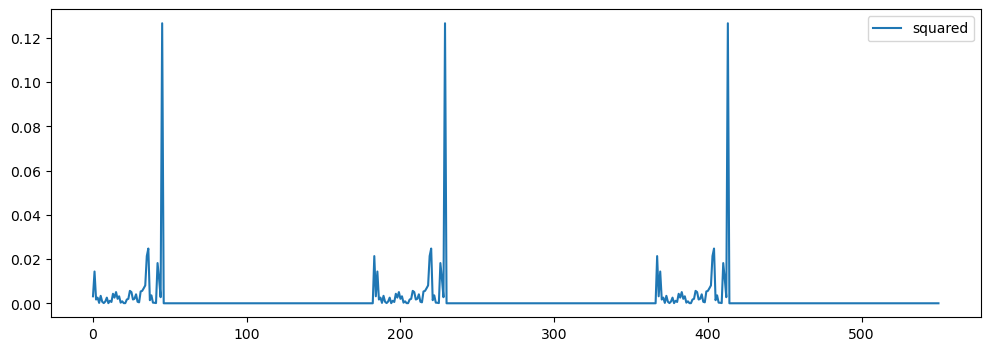

[1, 53, 213, 267, 397, 451]
1.0


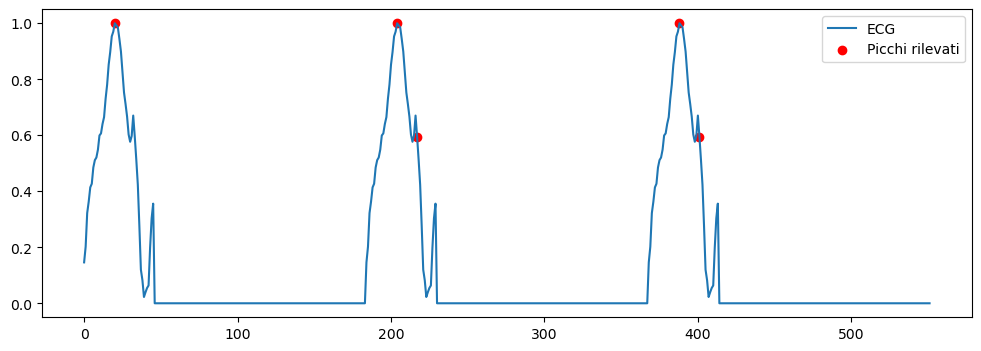

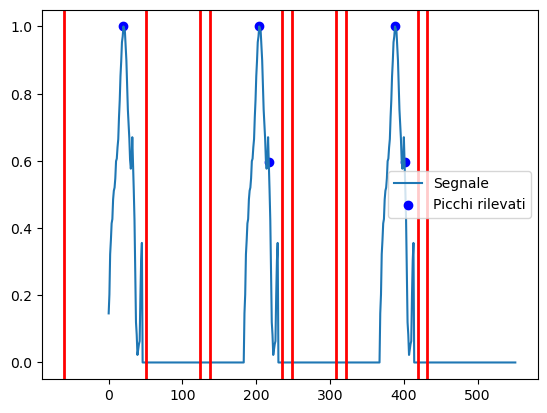

In [8]:
c = detect_r_peaks(ecg_signal_anomal2, fs=250)
#plt.plot(treshold)
plt.plot(ecg_signal_anomal2, label='Segnale')
plt.scatter(c, [ecg_signal_anomal2[p] for p in c], c='blue', label='Picchi rilevati')
#print(c, ecg_concat1[c])
for i in c:
    if i > 16 and i < ecg_concat1.shape[0]-31:
        plt.axvline(x=i-80, color='red', linestyle='-', linewidth=2)
        plt.axvline(x=i+31, color='red', linestyle='-', linewidth=2)
        
plt.legend()
